下载coco数据集

In [ ]:
!wget -p /content http://images.cocodataset.org/zips/train2014.zip

In [ ]:
!unzip /content/images.cocodataset.org/zips/train2014.zip

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab_Notebooks')

In [ ]:
!ls /content/drive/MyDrive/Colab_Notebooks

In [ ]:
import torch
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
from importlib import reload  # Py3 only; unneeded in py2.
net = reload(net)
func = reload(func)

-----------epoch:  0-----------
True
loss: 1.103934 [    0/80000] 0.0%
loss: 0.288061 [  100/80000] 0.1%
loss: 0.082372 [  200/80000] 0.2%
loss: 0.100660 [  300/80000] 0.4%
loss: 0.049658 [  400/80000] 0.5%
loss: 0.045868 [  500/80000] 0.6%
loss: 0.016157 [  600/80000] 0.8%
loss: 0.031041 [  700/80000] 0.9%
loss: 0.012245 [  800/80000] 1.0%
loss: 0.026671 [  900/80000] 1.1%
loss: 0.013964 [ 1000/80000] 1.2%
loss: 0.366790 [ 1100/80000] 1.4%
loss: 0.017307 [ 1200/80000] 1.5%
loss: 0.007480 [ 1300/80000] 1.6%
loss: 0.005446 [ 1400/80000] 1.8%
loss: 0.006342 [ 1500/80000] 1.9%
loss: 0.013307 [ 1600/80000] 2.0%
loss: 0.002423 [ 1700/80000] 2.1%
loss: 0.003990 [ 1800/80000] 2.2%
loss: 0.006286 [ 1900/80000] 2.4%
loss: 0.002933 [ 2000/80000] 2.5%
loss: 0.002098 [ 2100/80000] 2.6%
loss: 0.002462 [ 2200/80000] 2.8%
loss: 0.011305 [ 2300/80000] 2.9%
loss: 0.001884 [ 2400/80000] 3.0%
loss: 0.001826 [ 2500/80000] 3.1%
loss: 0.004856 [ 2600/80000] 3.2%
loss: 0.002610 [ 2700/80000] 3.4%
loss: 0.094

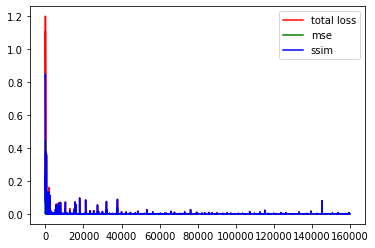

In [ ]:
import PIL.Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import os
import torch.utils.data as Data
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
import net
import func


class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_labels = os.listdir(img_dir)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels[idx])
        image = PIL.Image.open(img_path)
        label = 0
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


setup_seed(40)


def train(dataloader, model, loss_fn, optimizer):
    print(next(model.parameters()).is_cuda)
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
      X_gpu = X.to(device)
      output = model(X_gpu)
      train_loss = loss_fn(output, X_gpu)
      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()
      train_loss_all.append(train_loss.item())
      train_loss_mse.append(loss_fn.mse.item())
      train_loss_ssim.append(loss_fn.ssim.item())
      if batch % 50 == 0:
        loss, current = train_loss.item(), batch * len(X)
        print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}] {(current/size*100):>0.1f}%")


def test(dataloader, model, loss_fn):
    batch_size = len(dataloader)
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
          X = X.to(device)
          pred = model(X)
          test_loss += loss_fn(pred, X).item()
    test_loss /= batch_size
    print(f"Avg loss: {test_loss:>8f}")

path = '/content/train2014'
# path = '/content/drive/MyDrive/train2014'
custom_dataset = CustomImageDataset(path,
                   transform=transforms.Compose([transforms.Grayscale(num_output_channels=1),
                        transforms.Resize([256, 256]),
                        transforms.ToTensor(),
                        ]),)
custom_size = len(custom_dataset)
train_size = 80000
test_size = custom_size - train_size
train_dataset, test_dataset = torch.utils.data.random_split(custom_dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=2)

fusionNet = net.DenseFuse().to(device)
optimizer = torch.optim.Adam(fusionNet.parameters(), lr=0.0001)
loss_fn = func.LossFunc(lam=1, window_size=5)
train_loss_all = []
train_loss_mse = []
train_loss_ssim = []

for epoch in range(4):
    print(f'-----------epoch:{epoch:>3}-----------')
    train(train_loader, fusionNet, loss_fn, optimizer)
    test(test_loader, fusionNet, loss_fn)

plt.figure()
plt.plot(train_loss_all, "r-", label='total loss')
plt.plot(train_loss_mse, "g-", label='mse')
plt.plot(train_loss_ssim, "b-", label='ssim')
plt.legend()
plt.show()
torch.save(fusionNet.state_dict(), 'model_weights_coco_ssim_mse.pth')

In [ ]:
plt.figure()
plt.plot(train_loss_mse[:500], "g-", label='mse')
plt.plot(train_loss_ssim[:500], "b-", label='ssim')
plt.plot(train_loss_all[:500], "r-", label='total loss')
plt.legend()
plt.show()

In [ ]:
def text_save(filename, data):#filename为写入CSV文件的路径，data为要写入数据列表.
    file = open(filename,'a')
    for i in range(len(data)):
        s = str(data[i]).replace('[','').replace(']','')#去除[],这两行按数据不同，可以选择
        s = s.replace("'",'').replace(',','') +'\n'   #去除单引号，逗号，每行末尾追加换行符
        file.write(s)
    file.close()
    print("保存成功")

In [ ]:
text_save('loss_all.csv', train_loss_all)
text_save('loss_mse.csv', train_loss_mse)
text_save('loss_ssim.csv', train_loss_ssim)